In [253]:
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mpl_lines
import numpy as np
import cmasher as cmr

from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, mark_inset, InsetPosition, BboxConnector, TransformedBbox)
from matplotlib.transforms import (Bbox)

%matplotlib widget

# code modified to change negative values to positive ones
def lmap(f,x):
    return list(map(f,x))

# code modified to change negative values to positive ones
def lfilter(f,x):
    return list(filter(f,x))

def loadCSV(path, x_id=0, y_id=1):
    with open(path) as inp:
        lines = inp.read().split("\n")[1:-2]
        rows = lmap(lambda l: lmap(float, l.strip().split(",")), lines)

        return {"x": lmap(lambda r: r[x_id], rows), "y": lmap(lambda r: r[y_id], rows)}

def loadResultsCSV(path):
    def _f(x):
        if(x == "True"):
            return True
        elif (x=="False"):
            return False
        else:
            return float(x)
        
    with open(path) as inp:
        lines = inp.read().strip().split("\n")[1:]
        rows = lmap(
            lambda l: 
                lmap(
                _f, 
                l.strip().split(",")
            ), 
            lines
        )

        return ({
            "length": lines.__len__(),
            "d": lmap(lambda r: r[0], rows), 
            "o": lmap(lambda r: r[1], rows),
            "k": lmap(lambda r: r[2], rows),
            "ang": lmap(lambda r: r[3], rows),
            "t": lmap(lambda r: r[4], rows),
            "avg": lmap(lambda r: r[5], rows),
            "dev": lmap(lambda r: r[6], rows),
            "std": lmap(lambda r: r[7], rows),
            "switch": lmap(lambda r: r[8], rows),
            "der_avg": lmap(lambda r: r[9], rows),
            "linfit_m": lmap(lambda r: r[10], rows),
        }, lines.__len__())

In [254]:
# load the results data
(data, _len) = loadResultsCSV("./results.csv")

# Generate D and K axis values
D = []
d = 7
while d < 13:
    D.append(d)
        
    if d < 10:
        d = d + 0.1
    elif d < 14:
        d = d + 0.25
    else:
        d = d + 0.5
        
    d = round(d * 1000) / 1000

K = []
k = 0
while k <= 7:    
    K.append(k)

    if k < 2:
        k = k + 0.01
    elif k < 4:
        k = k + 0.025
    else:
        k = k + 0.1
    k = round(k * 1000) / 1000

# Generate the output plot arrays
D = np.array(D)
K = np.array(K)
C1 = np.full(shape=(K.__len__(), D.__len__()), fill_value=0, dtype=float)
C2 = np.full(shape=(K.__len__(), D.__len__()), fill_value=0, dtype=float)
C3 = np.full(shape=(K.__len__(), D.__len__()), fill_value=0, dtype=float)

# constants
spinner_r = 3.59
plot_in_terms_of_spinner_r = False

# plot options
max_offset = 0.5
max_avg_dev = 0.1

# go through all the data and set the appropriate plot values for each plot
for i in range(_len):
    try:
        d_id = np.where(D == data["d"][i])[0][0]
        k_id = np.where(K == data["k"][i])[0][0]

        # --------------------------------- PLOT 1 ---------------------------------
        C1[k_id, d_id] = None
        if not data["switch"][i]:
            if abs(data["linfit_m"][i]) < 1e-3: 
                # stable mode
                if -data["avg"][i] > 0.7:
                    C1[k_id, d_id] = -round(data["avg"][i])
                elif -data["avg"][i] > 0.48:
                    C1[k_id, d_id] = 0.5
                else:
                    C1[k_id, d_id] = 0.3333
        
        # --------------------------------- PLOT 2 ---------------------------------
        # -1 = default
        # 0 = stable mode
        # 3 = low interaction
        # 1 = equilibrium around 0
        # 2 = chaos
        C2[k_id, d_id] = -1
        if not data["switch"][i]:
            if abs(data["linfit_m"][i]) < 1e-3: 
                # stable mode
                C2[k_id, d_id] = 0
            else:
                # low interaction
                C2[k_id, d_id] = 3
        else:
            if abs(data["linfit_m"][i]) < 5e-5: 
                # equilibrium around 0
                C2[k_id, d_id] = 1
            else:
                # chaosv
                C2[k_id, d_id] = 2
                
        # --------------------------------- PLOT 3 ---------------------------------
        
        C3[k_id, d_id] = max(min(np.log10(data["dev"][i]), 2), -5)
    
    except:
        pass

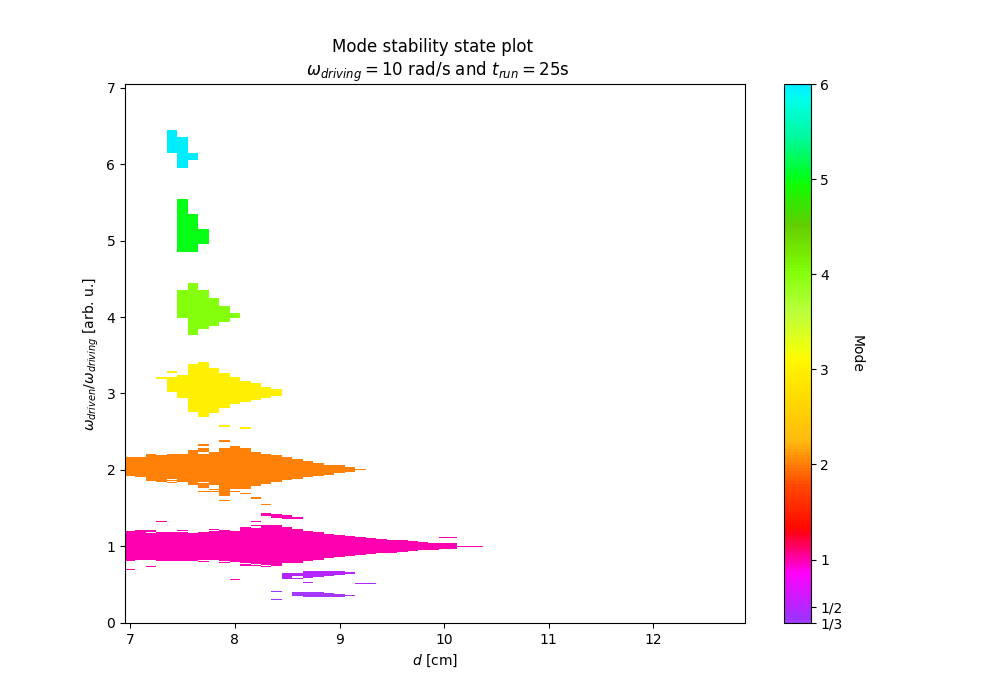

In [255]:
# PLOT 1 - total mode stability overview
plt.figure(figsize=(10, 7))
plt.title(
    "Mode stability state plot \n $\omega_{driving} = 10$ rad/s and $t_{run} = 25$s"
)
plt.ylabel("$\omega_{driven} / \omega_{driving}$ [arb. u.]")

if plot_in_terms_of_spinner_r:
    plt.xlabel("$d$ [$\mathbb{S}_r$] ($\mathbb{S}_r$ = " + str(spinner_r) + "cm)")
    plt.pcolormesh(D / spinner_r, K, C1, cmap=cmr.get_sub_cmap("gist_ncar_r", 0.15, 0.8))
else:
    plt.xlabel("$d$ [cm]")
    plt.pcolormesh(D, K, C1, cmap=cmr.get_sub_cmap("gist_ncar_r", 0.15, 0.8))

cbar = plt.colorbar(ticks=[1 / 3, 1 / 2, 1, 2, 3, 4, 5, 6, 7])
cbar.ax.set_yticklabels(["1/3", "1/2", "1", "2", "3", "4", "5", "6", "7"])
cbar.set_label("Mode", rotation=270, labelpad=15)

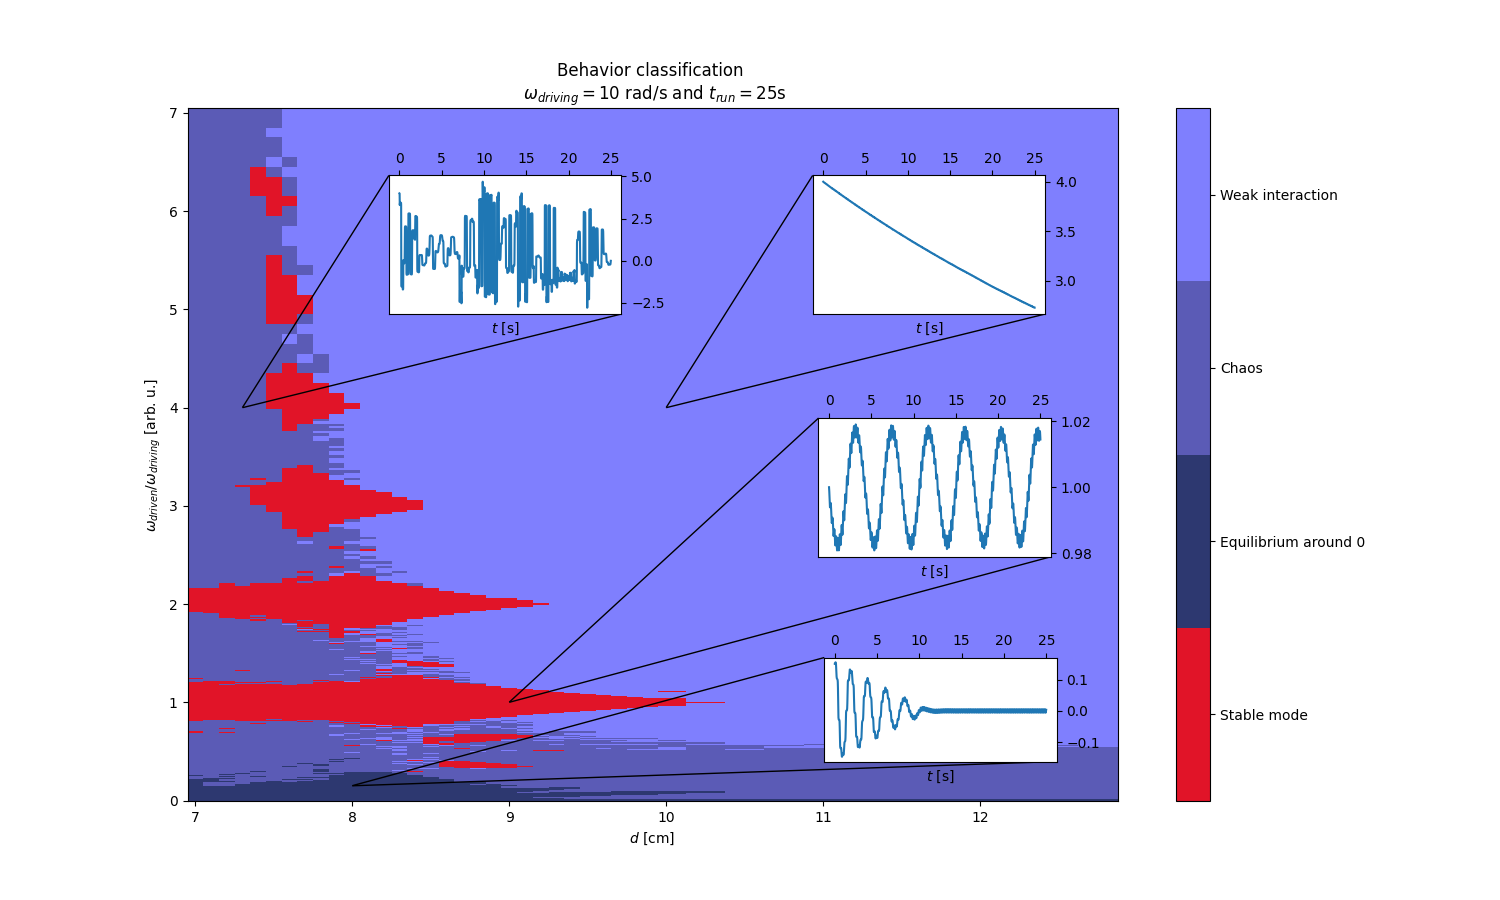

In [256]:
# PLOT 2 - behavior classification

# -1 = default
# 0 = stable mode
# 3 = low interaction
# 1 = equilibrium around 0
# 2 = chaos

fig, ax = plt.subplots(figsize=(15, 9))
plt.title(
    "Behavior classification \n $\omega_{driving} = 10$ rad/s and $t_{run} = 25$s"
)
plt.ylabel("$\omega_{driven} / \omega_{driving}$ [arb. u.]")

if plot_in_terms_of_spinner_r:
    plt.xlabel("$d$ [$\mathbb{S}_r$] ($\mathbb{S}_r$ = " + str(spinner_r) + "cm)")
    plt.pcolormesh(
        D / spinner_r, K, C2, cmap=cmr.get_sub_cmap("gist_stern", 0.08, 0.5, N=4)
    )
else:
    plt.xlabel("$d$ [cm]")
    plt.pcolormesh(D, K, C2, cmap=cmr.get_sub_cmap("gist_stern", 0.08, 0.5, N=4))

cbar = plt.colorbar()
cbar.set_ticks([3 / 4 - 3 / 8, 2 * 3 / 4 - 3 / 8, 3 * 3 / 4 - 3 / 8, 3 - 3 / 8])
cbar.ax.set_yticklabels(
    ["Stable mode", "Equilibrium around 0", "Chaos", "Weak interaction"]
)


def make_inset(d, k, w=0.25, h=0.2, pad=(0.1, 0.125)):
    (xmin, xmax) = ax.get_xlim()
    (ymin, ymax) = ax.get_ylim()

    dat = loadCSV(f"./runs/d={d:.4f}_o={10:.2f}_k={k:.3f}_ang={0.:.4f}_t={25:.3f}.csv")
    
    if plot_in_terms_of_spinner_r:
        d = d/spinner_r

    inset_ax = inset_axes(
        ax,
        width=str(w * 100) + "%",
        height=str(h * 100) + "%",
        bbox_to_anchor=(
            (d - xmin) / (xmax - xmin) + pad[0],
            (k - ymin) / (ymax - ymin) + pad[1],
            1,
            1,
        ),
        loc=3,
        bbox_transform=ax.transAxes,
    )

    inset_ax.set_xlabel("$t$ [s]", labelpad=5)
    inset_ax.set_xticks(np.round(np.linspace(0, dat["x"][-1], 6)))
    inset_ax.xaxis.tick_top()

    inset_ax.yaxis.tick_right()

    inset_ax.plot(dat["x"], lmap(lambda y: -y, dat["y"]))

    # ip = InsetPosition(ax,[(d-xmin)/(xmax-xmin) + pad[0], (k-ymin)/(ymax-ymin) + pad[1],w,h])
    # inset_ax.set_axes_locator(ip)
    # ax.indicate_inset_zoom(inset_ax, )

    bb = Bbox.from_bounds(0, 0, 0.1, 0.1).anchored(
        ((d - xmin) / (xmax - xmin), (k - ymin) / (ymax - ymin)),
        ax.bbox,
    )
    p1 = BboxConnector(inset_ax.bbox, bb, 2)
    p2 = BboxConnector(inset_ax.bbox, bb, 4)
    ax.add_patch(p1)
    ax.add_patch(p2)


make_inset(9, 1, pad=(0.325, 0.2))
make_inset(8, 0.15, h=0.15, pad=(0.5, 0.025))
make_inset(10, 4, pad=(0.15, 0.125))
make_inset(7.3, 4, pad=(0.15, 0.125))

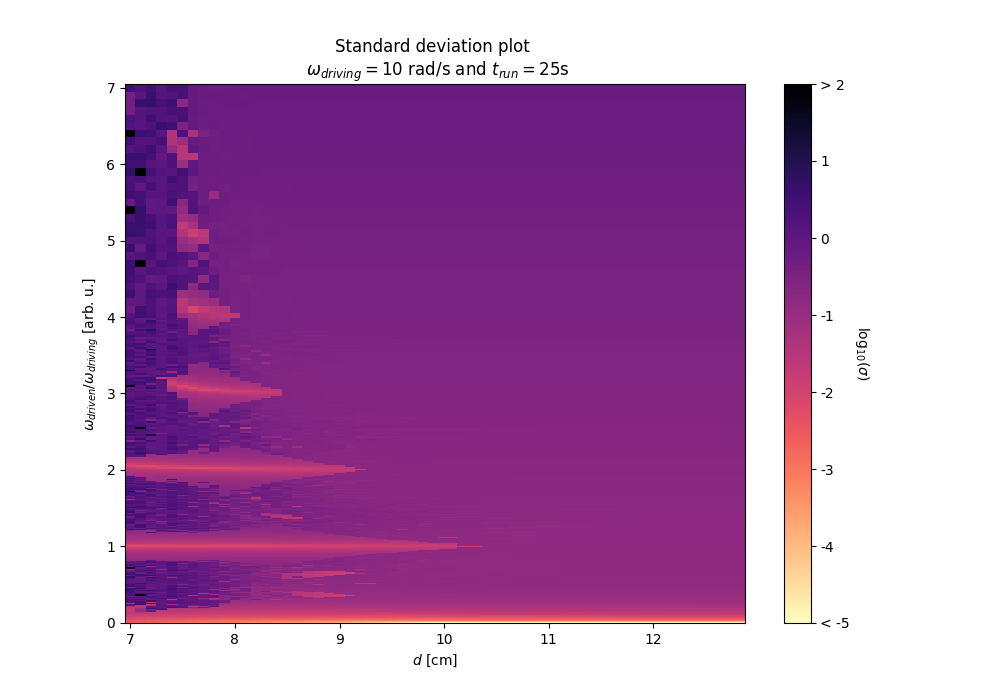

In [257]:
# PLOT 3 - deviation plot
plt.figure(figsize=(10, 7))
plt.title(
    "Standard deviation plot \n $\omega_{driving} = 10$ rad/s and $t_{run} = 25$s"
)
plt.ylabel("$\omega_{driven} / \omega_{driving}$ [arb. u.]")

if plot_in_terms_of_spinner_r:
    plt.xlabel("$d$ [$\mathbb{S}_r$] ($\mathbb{S}_r$ = " + str(spinner_r) + "cm)")
    plt.pcolormesh(D / spinner_r, K, C3, cmap="magma_r")
else:
    plt.xlabel("$d$ [cm]")
    plt.pcolormesh(D, K, C3, cmap="magma_r")

cbar = plt.colorbar()
cbar.set_label("$\log_{10}(\sigma)$", rotation=270, labelpad=15)
cbar.set_ticks(np.linspace(-5, 2, 8))
cbar.ax.set_yticklabels(["< -5", "-4", "-3", "-2", "-1", "0", "1", "> 2"])
pass